# M2177.003100 Deep Learning <br> Assignment #4 Implementing Conditional Generative Adversarial Nets - part3 Labeld Face Data

Copyright (C) Data Science Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jaeyoon Yoo, November 2017

In this notebook, you will learn how to implement conditional Genverative Adversarial Nets (cGANs) <br>
The goal here is to build GANs that draw a face given its label. You can draw a black male/black female/white male/white female as you gives an input at the end of training. <br> 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a zipped file called *[Your team number].zip*. Please submit this file on ETL. &nbsp;&nbsp; (Usage: ./*CollectSubmission.sh* &nbsp; Team_#)

### Some helpful tutorials and references for assignment #3:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- [4] Mirza, Mehdi, and Simon Osindero. "Conditional generative adversarial nets." arXiv preprint arXiv:1411.1784 (2014).
- [5] Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

## 0. Download and load Face datasets
Unzip the face_dataset.tar.gz in data directory as follows.<br>
**cd ./data**<br>
**tar -xf face_dataset.tar.gz**<br>

Following is how to load the data. Modify  *data_dir* to be the directory the data is in. Or you will get an error.<br>

In [1]:
from utils import load_face
data_dir = './data/face_dataset'
im, label = load_face(data_dir)

There are 13143 images and corresponding lables. Labels have three values. Following is the detail:

Label1 - Male/Female : positive value means male<br>
Label2 - White/Not white : positive value means White<br>
Lable3 - Black/Not black : positive value menas black<br>
The large value represents the more property it has.

Note that the labels are not normalized and check the data by runing and modifying following code

In [ ]:
import pylab as plt
for i in range(5):
    plt.imshow(im[i])
    plt.show()
    print(label[i])
    print(im[i].shape)

## <a name="1"></a> 1. Build a network

In this section, you will implement neural networks for (1) generative model (2) discriminative model. You can reuse your code in part1 and improve it. Just write the code in whatever way you find most clear.

In [4]:
from utils import load_face
from utils import getNext_batch
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import sample_label_face
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

from ops import conv2d
from ops import lrelu
from ops import de_conv
from ops import fully_connect
from ops import conv_cond_concat
from ops import batch_normal

import tensorflow as tf
import numpy as np

learning_rate = 0.0002
batch_size = 128
EPOCH = 100
loss_step    = 50
display_step = 50
sample_size = 100
y_dim = 3
channel = 3
output_size = 64

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

It is time for a generative model. You can change anything including the argument If you need. Feel free to change it and improve it.

In [5]:
def gern_net(batch_size, z , y ,sample_size, y_dim, output_size):
    #### TODO ####
    with tf.variable_scope('gen'):
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b_init = tf.constant_initializer(0.0)

        # concat layer
        z_input = tf.reshape(z, [-1, 1, 1, sample_size])
        y_label = tf.reshape(y, [-1, 1, 1, y_dim])
        inputs = tf.concat([z, y], 1)
        
        # project layer
        proj_size = 4*4*1024
        W = tf.get_variable("W0", [sample_size + y_dim, proj_size], initializer=w_init)
        b = tf.get_variable("b0", [proj_size], initializer=b_init)
        projected = lrelu(batch_normal(fully_connect(inputs, W, b), scope='bn0'))
        reshape = tf.reshape(projected, [batch_size, 4, 4, 1024])

        # 1st hidden layer
        W = tf.get_variable("W1", [5, 5, 512, 1024], initializer=w_init)
        b = tf.get_variable("b1", [512], initializer=b_init)
        deconv1 = lrelu(batch_normal(de_conv(reshape, W, b, [batch_size, 8, 8, 512]), scope='bn1'))

        # 2nd hidden layer
        W = tf.get_variable("W2", [5, 5, 256, 512], initializer=w_init)
        b = tf.get_variable("b2", [256], initializer=b_init)
        deconv2 = lrelu(batch_normal(de_conv(deconv1, W, b, [batch_size, 16, 16, 256]), scope='bn2'))
        
        # 3nd hidden layer
        W = tf.get_variable("W3", [5, 5, 128, 256], initializer=w_init)
        b = tf.get_variable("b3", [128], initializer=b_init)
        deconv3 = lrelu(batch_normal(de_conv(deconv2, W, b, [batch_size, 32, 32, 128]), scope='bn3'))

        # output layer
        W = tf.get_variable("W4", [5, 5, 3, 128], initializer=w_init)
        b = tf.get_variable("b4", [3], initializer=b_init)
        deconv3 = de_conv(deconv3, W, b, [batch_size, 64, 64, 3])
        o = tf.nn.tanh(deconv3)

        return o
    

Now, it's time for a discriminative model. Again, you can change anything if you need

In [6]:
def dis_net(data_array , y, batch_size, y_dim, reuse=False):
    #### TODO ####
    with tf.variable_scope('dis', reuse=reuse):
        w_init = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b_init = tf.constant_initializer(0.0)

        yb = tf.reshape(y, [batch_size, 1, 1, y_dim])
        x = conv_cond_concat(data_array, yb)

        # 1st hidden layer
        W = tf.get_variable("W1", [5, 5, x.get_shape()[-1], channel+y_dim], initializer=w_init)
        b = tf.get_variable("b1", [channel+y_dim], initializer=b_init)
        conv1 = lrelu(conv2d(x, W, b))
        
        # 2nd hidden layer
        W = tf.get_variable("W2", [5, 5, conv1.get_shape()[-1], 64], initializer=w_init)
        b = tf.get_variable("b2", [64], initializer=b_init)
        conv2 = lrelu(batch_normal(conv2d(conv1, W, b), scope='bn2'))
        conv2_flatten = tf.reshape(conv2, [batch_size, -1])
        
        # 3rd hidden layer
        W = tf.get_variable("W3", [conv2_flatten.get_shape()[-1], 1024], initializer=w_init)
        b = tf.get_variable("b3", [1024], initializer=b_init)
        out3 = lrelu(batch_normal(fully_connect(conv2_flatten, W, b), scope='bn3'))

        # output layer
        W = tf.get_variable("W4", [1024, 1], initializer=w_init)
        b = tf.get_variable("b4", [1], initializer=b_init)
        logits = fully_connect(out3, W, b)
        o = tf.nn.sigmoid(logits)

        return o, logits


## <a name="2"></a> 2. Build a main part and train it

In this section, you will implement the main part. Then run the code and check the model draws the face properly.

When you are done, run the following to check your implementations.

Following code will make 'samples_for_test' directory that resulting image will be saved in. You can change the directory as you want.

In [8]:
from utils import load_mnist
from utils import save_images
from utils import vis_square
from utils import sample_label
from utils import getNext_batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

sample_dir = 'samples_for_test_faces_1'

if os.path.exists(sample_dir) == False:
    os.makedirs(sample_dir)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Feel free to fill in the main part. You can copy the part1 code or write your own code.

Your goal is to **generate 4 row and 8 column images(32 total)**.

**Each row should correspond to each label**.

First row : black male<br>
Second row: black female<br>
Third row : white male<br>
Fourth row: white female<br>

You can use "save_images" method in *utils.py* to align generated image by 4*8. See part1 code to get how to use it.

You must show **at least three generated images**. (At the beginning of ,in the midway of, at the end of training.)


EPOCH 0 step 50: D: loss = 1.4089696 G: loss=0.6731839 
EPOCH 0 step 100: D: loss = 1.3917630 G: loss=0.6833516 


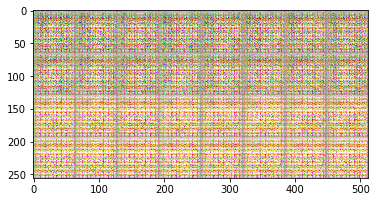

EPOCH 1 step 150: D: loss = 1.3925083 G: loss=0.6816905 
EPOCH 1 step 200: D: loss = 1.3869667 G: loss=0.6880974 
EPOCH 2 step 250: D: loss = 1.3865205 G: loss=0.6886978 
EPOCH 2 step 300: D: loss = 1.3867168 G: loss=0.6921425 
EPOCH 3 step 350: D: loss = 1.3872873 G: loss=0.6911185 
EPOCH 3 step 400: D: loss = 1.3878458 G: loss=0.6847998 
EPOCH 4 step 450: D: loss = 1.3859541 G: loss=0.6949235 
EPOCH 4 step 500: D: loss = 1.3890820 G: loss=0.6917472 
EPOCH 5 step 550: D: loss = 1.3848648 G: loss=0.6928584 
EPOCH 5 step 600: D: loss = 1.3859682 G: loss=0.6876678 
EPOCH 6 step 650: D: loss = 1.3861389 G: loss=0.6910431 
EPOCH 6 step 700: D: loss = 1.3884629 G: loss=0.6895720 
EPOCH 7 step 750: D: loss = 1.3867908 G: loss=0.6903398 
EPOCH 7 step 800: D: loss = 1.3889232 G: loss=0.6880007 
EPOCH 8 step 850: D: loss = 1.3816292 G: loss=0.6909189 
EPOCH 8 step 900: D: loss = 1.3781579 G: loss=0.6908605 
EPOCH 9 step 950: D: loss = 1.3890665 G: loss=0.6786436 
EPOCH 9 step 1000: D: loss = 1.

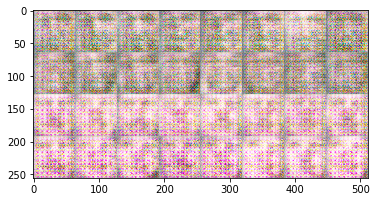

EPOCH 11 step 1150: D: loss = 1.3850443 G: loss=0.6943590 
EPOCH 11 step 1200: D: loss = 1.3816667 G: loss=0.6924077 
EPOCH 12 step 1250: D: loss = 1.3869677 G: loss=0.6984451 
EPOCH 12 step 1300: D: loss = 1.3805785 G: loss=0.6877453 
EPOCH 13 step 1350: D: loss = 1.3796101 G: loss=0.6980669 
EPOCH 13 step 1400: D: loss = 1.3814150 G: loss=0.6882671 
EPOCH 14 step 1450: D: loss = 1.3834355 G: loss=0.6928384 
EPOCH 14 step 1500: D: loss = 1.3866012 G: loss=0.6846616 
EPOCH 15 step 1550: D: loss = 1.3777742 G: loss=0.6900145 
EPOCH 15 step 1600: D: loss = 1.3824210 G: loss=0.6928911 
EPOCH 16 step 1650: D: loss = 1.3798814 G: loss=0.6911778 
EPOCH 16 step 1700: D: loss = 1.3827038 G: loss=0.7023178 
EPOCH 17 step 1750: D: loss = 1.3819321 G: loss=0.6967088 
EPOCH 17 step 1800: D: loss = 1.3820548 G: loss=0.6882726 
EPOCH 18 step 1850: D: loss = 1.3785158 G: loss=0.6883008 
EPOCH 18 step 1900: D: loss = 1.3791840 G: loss=0.6954387 
EPOCH 19 step 1950: D: loss = 1.3845875 G: loss=0.686832

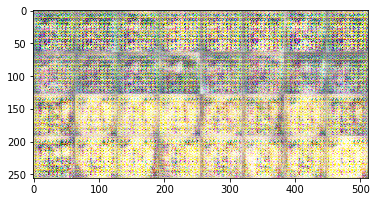

EPOCH 21 step 2150: D: loss = 1.3795244 G: loss=0.6938219 
EPOCH 21 step 2200: D: loss = 1.3745415 G: loss=0.6936589 
EPOCH 22 step 2250: D: loss = 1.3859903 G: loss=0.6896499 
EPOCH 22 step 2300: D: loss = 1.3800449 G: loss=0.6963515 
EPOCH 23 step 2350: D: loss = 1.3771498 G: loss=0.6893214 
EPOCH 23 step 2400: D: loss = 1.3779856 G: loss=0.6892476 
EPOCH 24 step 2450: D: loss = 1.3810353 G: loss=0.6852133 
EPOCH 24 step 2500: D: loss = 1.3628740 G: loss=0.6926752 
EPOCH 24 step 2550: D: loss = 1.3755574 G: loss=0.6886090 
EPOCH 25 step 2600: D: loss = 1.3709290 G: loss=0.6901092 
EPOCH 25 step 2650: D: loss = 1.3653324 G: loss=0.6923531 
EPOCH 26 step 2700: D: loss = 1.3545405 G: loss=0.6935518 
EPOCH 26 step 2750: D: loss = 1.3557332 G: loss=0.7087356 
EPOCH 27 step 2800: D: loss = 1.3503331 G: loss=0.6912504 
EPOCH 27 step 2850: D: loss = 1.3567443 G: loss=0.6917866 
EPOCH 28 step 2900: D: loss = 1.3534567 G: loss=0.7073479 
EPOCH 28 step 2950: D: loss = 1.3560967 G: loss=0.714168

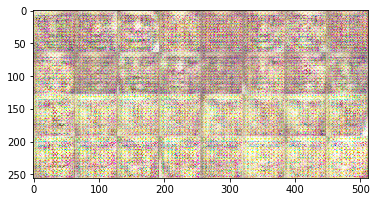

EPOCH 31 step 3200: D: loss = 1.3324906 G: loss=0.7006786 
EPOCH 31 step 3250: D: loss = 1.3955619 G: loss=0.7601696 
EPOCH 32 step 3300: D: loss = 1.2766247 G: loss=0.7351332 
EPOCH 32 step 3350: D: loss = 1.3488193 G: loss=0.7382002 
EPOCH 33 step 3400: D: loss = 1.2462529 G: loss=0.7223286 
EPOCH 33 step 3450: D: loss = 1.2654701 G: loss=0.7261176 
EPOCH 34 step 3500: D: loss = 1.2491188 G: loss=0.7262008 
EPOCH 34 step 3550: D: loss = 1.2613173 G: loss=0.7252780 
EPOCH 35 step 3600: D: loss = 1.2941260 G: loss=0.7264755 
EPOCH 35 step 3650: D: loss = 1.2459905 G: loss=0.7638959 
EPOCH 36 step 3700: D: loss = 1.2344190 G: loss=0.7596962 
EPOCH 36 step 3750: D: loss = 1.2533305 G: loss=0.7326262 
EPOCH 37 step 3800: D: loss = 1.2475404 G: loss=0.7555726 
EPOCH 37 step 3850: D: loss = 1.2342970 G: loss=0.7469338 
EPOCH 38 step 3900: D: loss = 1.2039357 G: loss=0.7404289 
EPOCH 38 step 3950: D: loss = 1.2180840 G: loss=0.7574458 
EPOCH 39 step 4000: D: loss = 1.2579474 G: loss=0.784553

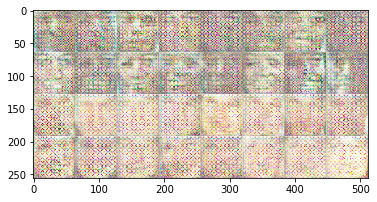

EPOCH 41 step 4200: D: loss = 1.1808006 G: loss=0.7493528 
EPOCH 41 step 4250: D: loss = 1.1803851 G: loss=0.7733451 
EPOCH 42 step 4300: D: loss = 1.2104766 G: loss=0.7678591 
EPOCH 42 step 4350: D: loss = 1.1742296 G: loss=0.7767077 
EPOCH 43 step 4400: D: loss = 1.1605532 G: loss=0.7756503 
EPOCH 43 step 4450: D: loss = 1.0840116 G: loss=0.8315040 
EPOCH 44 step 4500: D: loss = 1.1528137 G: loss=0.8016125 
EPOCH 44 step 4550: D: loss = 1.1526634 G: loss=0.8020164 
EPOCH 45 step 4600: D: loss = 1.1044669 G: loss=0.8314340 
EPOCH 45 step 4650: D: loss = 1.1541312 G: loss=0.8375651 
EPOCH 46 step 4700: D: loss = 1.0817070 G: loss=0.8466144 
EPOCH 46 step 4750: D: loss = 1.0482144 G: loss=0.8531914 
EPOCH 47 step 4800: D: loss = 1.0765717 G: loss=0.8589845 
EPOCH 47 step 4850: D: loss = 1.0504605 G: loss=0.8587204 
EPOCH 48 step 4900: D: loss = 1.0356712 G: loss=0.8618007 
EPOCH 48 step 4950: D: loss = 1.0741609 G: loss=0.8690298 
EPOCH 49 step 5000: D: loss = 1.0478982 G: loss=0.847579

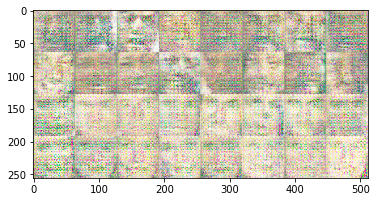

EPOCH 51 step 5250: D: loss = 0.9317807 G: loss=0.9232363 
EPOCH 51 step 5300: D: loss = 0.9659846 G: loss=0.9182476 
EPOCH 52 step 5350: D: loss = 0.9179384 G: loss=0.9437083 
EPOCH 52 step 5400: D: loss = 0.9464691 G: loss=0.8910668 
EPOCH 53 step 5450: D: loss = 0.9983990 G: loss=0.9673835 
EPOCH 53 step 5500: D: loss = 1.0135875 G: loss=0.9119248 
EPOCH 54 step 5550: D: loss = 0.9458948 G: loss=0.9636440 
EPOCH 54 step 5600: D: loss = 0.9621960 G: loss=0.9457183 
EPOCH 55 step 5650: D: loss = 0.9209321 G: loss=1.0152690 
EPOCH 55 step 5700: D: loss = 1.2109144 G: loss=0.8610888 
EPOCH 56 step 5750: D: loss = 0.8708023 G: loss=1.0903034 
EPOCH 56 step 5800: D: loss = 0.8476391 G: loss=1.0260308 
EPOCH 57 step 5850: D: loss = 0.7582446 G: loss=1.0705056 
EPOCH 57 step 5900: D: loss = 0.9731032 G: loss=1.0914290 
EPOCH 58 step 5950: D: loss = 0.7745328 G: loss=1.0581889 
EPOCH 58 step 6000: D: loss = 0.8254744 G: loss=0.9964150 
EPOCH 59 step 6050: D: loss = 0.8407349 G: loss=1.064382

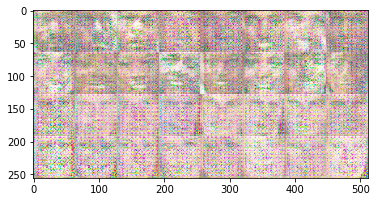

EPOCH 61 step 6250: D: loss = 0.8047098 G: loss=1.0545219 
EPOCH 61 step 6300: D: loss = 0.8686548 G: loss=1.0420396 
EPOCH 62 step 6350: D: loss = 0.8085662 G: loss=1.0726552 
EPOCH 62 step 6400: D: loss = 0.7960613 G: loss=1.0441420 
EPOCH 63 step 6450: D: loss = 0.7086999 G: loss=1.1037855 
EPOCH 63 step 6500: D: loss = 0.8202028 G: loss=1.0730616 
EPOCH 64 step 6550: D: loss = 0.7736392 G: loss=1.0991098 
EPOCH 64 step 6600: D: loss = 0.8552369 G: loss=1.0540434 
EPOCH 65 step 6650: D: loss = 0.8281301 G: loss=1.1317132 
EPOCH 65 step 6700: D: loss = 0.8603226 G: loss=1.1300201 
EPOCH 66 step 6750: D: loss = 0.7920883 G: loss=1.0649235 
EPOCH 66 step 6800: D: loss = 0.7779791 G: loss=1.0937691 
EPOCH 67 step 6850: D: loss = 0.9562516 G: loss=1.1577541 
EPOCH 67 step 6900: D: loss = 0.7553456 G: loss=1.0947456 
EPOCH 68 step 6950: D: loss = 0.7380089 G: loss=1.1259489 
EPOCH 68 step 7000: D: loss = 0.7319002 G: loss=1.0690629 
EPOCH 69 step 7050: D: loss = 0.7787842 G: loss=1.138080

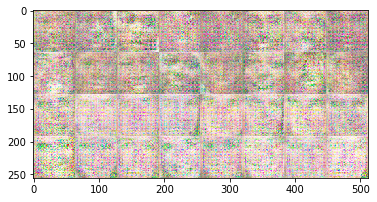

EPOCH 71 step 7250: D: loss = 0.7530304 G: loss=1.2052836 
EPOCH 71 step 7300: D: loss = 0.7463763 G: loss=1.2765768 
EPOCH 72 step 7350: D: loss = 0.6818988 G: loss=1.1816413 
EPOCH 72 step 7400: D: loss = 0.7065181 G: loss=1.2384636 
EPOCH 73 step 7450: D: loss = 0.6701981 G: loss=1.1591502 
EPOCH 73 step 7500: D: loss = 0.6589513 G: loss=1.1727679 
EPOCH 74 step 7550: D: loss = 0.6591210 G: loss=1.1806581 
EPOCH 74 step 7600: D: loss = 0.6561019 G: loss=1.2023401 
EPOCH 74 step 7650: D: loss = 0.6661242 G: loss=1.2059623 
EPOCH 75 step 7700: D: loss = 0.6569989 G: loss=1.2003566 
EPOCH 75 step 7750: D: loss = 0.6443624 G: loss=1.2010424 
EPOCH 76 step 7800: D: loss = 0.6176115 G: loss=1.2348943 
EPOCH 76 step 7850: D: loss = 0.6498017 G: loss=1.2181956 
EPOCH 77 step 7900: D: loss = 0.6468608 G: loss=1.2343941 
EPOCH 77 step 7950: D: loss = 0.6379777 G: loss=1.2191803 
EPOCH 78 step 8000: D: loss = 0.6090015 G: loss=1.2112703 
EPOCH 78 step 8050: D: loss = 0.6857217 G: loss=1.195769

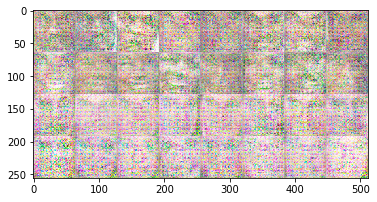

EPOCH 81 step 8300: D: loss = 0.5684794 G: loss=1.3784223 
EPOCH 81 step 8350: D: loss = 0.6150401 G: loss=1.3747568 
EPOCH 82 step 8400: D: loss = 0.5179807 G: loss=1.4435205 
EPOCH 82 step 8450: D: loss = 1.0388762 G: loss=1.6363957 
EPOCH 83 step 8500: D: loss = 0.5246801 G: loss=1.3505321 
EPOCH 83 step 8550: D: loss = 0.5410286 G: loss=1.3839300 
EPOCH 84 step 8600: D: loss = 0.5406634 G: loss=1.2857816 
EPOCH 84 step 8650: D: loss = 0.5475997 G: loss=1.4000217 
EPOCH 85 step 8700: D: loss = 0.6221484 G: loss=1.4565337 
EPOCH 85 step 8750: D: loss = 0.5355021 G: loss=1.4493058 
EPOCH 86 step 8800: D: loss = 0.5007201 G: loss=1.4460684 
EPOCH 86 step 8850: D: loss = 0.5330510 G: loss=1.3961037 
EPOCH 87 step 8900: D: loss = 0.6180997 G: loss=1.4396209 
EPOCH 87 step 8950: D: loss = 0.5520191 G: loss=1.3775400 
EPOCH 88 step 9000: D: loss = 0.5599874 G: loss=1.5677013 
EPOCH 88 step 9050: D: loss = 0.5542639 G: loss=1.3801997 
EPOCH 89 step 9100: D: loss = 0.4945949 G: loss=1.434390

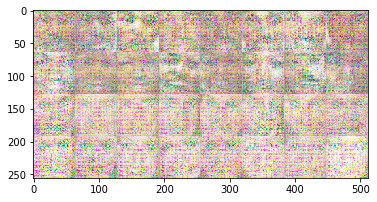

EPOCH 91 step 9300: D: loss = 0.4685467 G: loss=1.3519390 
EPOCH 91 step 9350: D: loss = 0.5039898 G: loss=1.3947660 
EPOCH 92 step 9400: D: loss = 0.5347536 G: loss=1.4742386 
EPOCH 92 step 9450: D: loss = 0.5063338 G: loss=1.4298416 
EPOCH 93 step 9500: D: loss = 0.4713729 G: loss=1.4566163 
EPOCH 93 step 9550: D: loss = 0.5449529 G: loss=1.4059017 
EPOCH 94 step 9600: D: loss = 0.4880433 G: loss=1.5011450 
EPOCH 94 step 9650: D: loss = 0.9408737 G: loss=1.6872830 
EPOCH 95 step 9700: D: loss = 0.4535665 G: loss=1.4804196 
EPOCH 95 step 9750: D: loss = 0.7548226 G: loss=1.7132365 
EPOCH 96 step 9800: D: loss = 0.4576123 G: loss=1.5588369 
EPOCH 96 step 9850: D: loss = 0.4701810 G: loss=1.5165024 
EPOCH 97 step 9900: D: loss = 0.4771466 G: loss=1.4774816 
EPOCH 97 step 9950: D: loss = 0.4758370 G: loss=1.6361518 
EPOCH 98 step 10000: D: loss = 0.4472934 G: loss=1.5168387 
EPOCH 98 step 10050: D: loss = 0.4235995 G: loss=1.6035435 
EPOCH 99 step 10100: D: loss = 0.5107868 G: loss=1.624

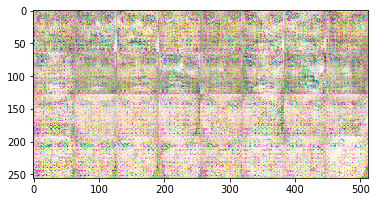

In [20]:
#### TODO ####
def new_sample_label_face(num):
    label_vector = np.zeros((num,3))
    for i in range(32):
        # row 1
        if i % 4 == 0:
            label_vector[i,0]= 2  # male
            label_vector[i,1]=-2  # not white
            label_vector[i,2]= 2  # black
        # row 2
        elif i % 4 == 1:
            label_vector[i,0]=-2  # female
            label_vector[i,1]=-2  # not white
            label_vector[i,2]= 2  # black
        # row 3
        elif i % 4 == 2:
            label_vector[i,0]= 2  # male
            label_vector[i,1]= 2  # white
            label_vector[i,2]=-2  # not black
        # row 4
        else:
            label_vector[i,0]=-2  # female
            label_vector[i,1]= 2  # white
            label_vector[i,2]=-2  # not black
    return label_vector

tf.reset_default_graph()

sample_z = np.random.uniform(-1 , 1 , size = [batch_size , sample_size])

y = tf.placeholder(tf.float32, [None , y_dim])

images = tf.placeholder(tf.float32, [batch_size, output_size, output_size, channel])

z = tf.placeholder(tf.float32, [None , sample_size])

fake_images = gern_net(batch_size, z , y ,sample_size, y_dim,output_size)

##the loss of gerenate network
D_pro , D_logits = dis_net(images, y , batch_size, y_dim,  False)

G_pro, G_logits = dis_net(fake_images , y , batch_size, y_dim, True)

# DEFINE LOSS FUNCTION #

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logits, labels=tf.ones_like(D_logits)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.zeros_like(G_logits)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=G_logits, labels=tf.ones_like(G_logits)))

#############

t_vars = tf.trainable_variables()

d_var = [var for var in t_vars if 'dis' in var.name]
g_var = [var for var in t_vars if 'gen' in var.name]

opti_D = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(D_loss , var_list=d_var)
opti_G = tf.train.AdamOptimizer(learning_rate=learning_rate , beta1=0.5).minimize(G_loss , var_list=g_var)

init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

checkpoint_dir = './gan_checkpoint/'
saver = tf.train.Saver()
with tf.Session(config=config) as sess:

    sess.run(init)
    e = 0
    step = 0

    while e <= EPOCH:
        batch_num = 0
        while batch_num < len(im) / batch_size - 1:

            step = step + 1

            realbatch_array , real_labels = getNext_batch(im , label , batch_num, batch_size)
            
            #Get the z
            batch_z = np.random.uniform(-1 , 1 , size=[batch_size , sample_size])

            _ = sess.run(opti_D, feed_dict={images:realbatch_array, z:batch_z , y:real_labels})
            _ = sess.run(opti_G, feed_dict={z: batch_z , y:real_labels})

            batch_num += 1

            if step % loss_step == 0:

                d_get_loss = sess.run(D_loss , feed_dict = {images:realbatch_array , z:batch_z , y:real_labels})
                g_get_loss = sess.run(G_loss , feed_dict = {z: batch_z , y:real_labels})
                print("EPOCH %d step %d: D: loss = %.7f G: loss=%.7f " % (e , step , d_get_loss , g_get_loss))

        if np.mod(e , 10) == 0:

            sample_images = sess.run(fake_images ,
                                               feed_dict={z:sample_z , y:new_sample_label_face(batch_size)})
            sample_images = sample_images[:32,:,:,:]
            image_name = './{}/train_{:02d}_{:04d}.png'.format(sample_dir , e , step)
            save_images(sample_images , [4,8] , image_name)
            saver.save(sess, checkpoint_dir + 'cgan_model', global_step=e, write_meta_graph=False)
        
            img = mpimg.imread(image_name)
            imgplot = plt.imshow(img)
            plt.show()

        e = e + 1
        batch_num = 0